# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

In [1]:
import tensorflow as tf

from tqdm import tqdm_notebook

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [2]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_val, y_val) = cifar10.load_data()
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(50000, 32, 32, 3) (50000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

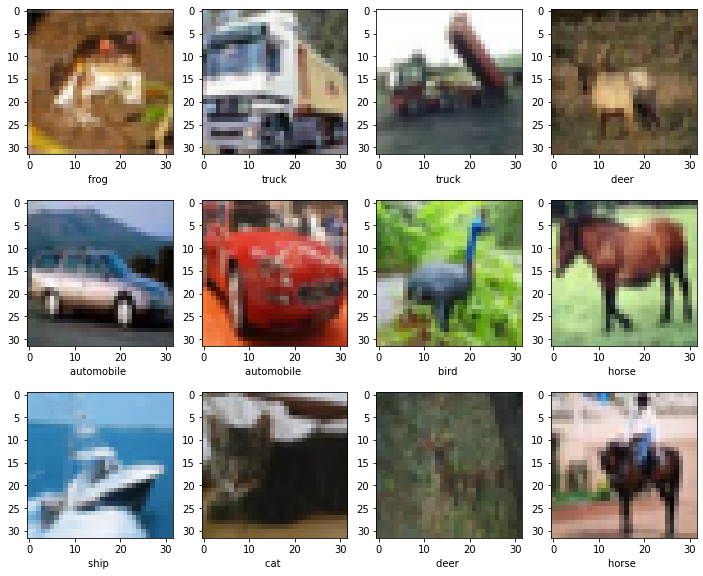

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [4]:
X_train = X_train / 255
X_val = X_val / 255
# X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [6]:
assert np.shape(X_train) == (50000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val))) <= 0.1
assert len(np.unique(X_val / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [7]:
import keras
from keras import layers as L
from keras import backend as K

In [8]:
from tensorflow.keras import utils as np_utils
y_train_cat, y_val_cat = (np_utils.to_categorical(y) for y in (y_train, y_val))

In [10]:
# Версия 2 - с keras вместо tensorflow.keras
K.clear_session()
model =  keras.Sequential([
    L.InputLayer(input_shape=(32, 32, 3)), # это, кажется, не обязательно - keras добавляет сам? https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer
    L.Flatten(),
    L.Dense(1024, activation="relu", input_shape=X_train.shape[1:]),
    L.Dense(128, activation='relu'), # relu отрицательных значений не дает - ничего? softmax для многоклассовой классификации
    L.Dense(32, activation='relu'),
    L.Dense(10, activation='softmax')]) # может попробовать без активации вообще - только выдача классов


In [11]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [25]:
callbacks = []

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train_cat,
          batch_size=32, 
          epochs=16,
          validation_split=0.2,
          validation_data=[X_val, y_val_cat])

Epoch 1/16
1250/1250 [==============================] - 29s 23ms/step - loss: 2.3060 - accuracy: 0.0995 - val_loss: 2.3026 - val_accuracy: 0.0977
Epoch 2/16
1250/1250 [==============================] - 28s 23ms/step - loss: 2.3028 - accuracy: 0.0992 - val_loss: 2.3028 - val_accuracy: 0.0952
Epoch 3/16
1250/1250 [==============================] - 29s 23ms/step - loss: 2.3028 - accuracy: 0.0986 - val_loss: 2.3028 - val_accuracy: 0.0952
Epoch 4/16
1250/1250 [==============================] - 28s 23ms/step - loss: 2.3028 - accuracy: 0.0986 - val_loss: 2.3026 - val_accuracy: 0.1014
Epoch 5/16
1250/1250 [==============================] - 29s 23ms/step - loss: 2.3028 - accuracy: 0.0972 - val_loss: 2.3027 - val_accuracy: 0.0977
Epoch 6/16
1250/1250 [==============================] - 28s 23ms/step - loss: 2.3027 - accuracy: 0.0979 - val_loss: 2.3029 - val_accuracy: 0.0952
Epoch 7/16
1250/1250 [==============================] - 29s 23ms/step - loss: 2.3028 - accuracy: 0.0995 - val_loss: 2.3027 -

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [14]:
from sklearn.metrics import accuracy_score, classification_report
y_pred_labels = np.argmax(model.predict(X_val),axis=1)
test_acc = accuracy_score(y_val, y_pred_labels)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.1


AssertionError: ignored

In [ ]:
print(classification_report(y_val, y_pred_labels))

              precision    recall  f1-score   support

           0       0.09      0.09      0.09       973
           1       0.11      0.08      0.09       979
           2       0.11      0.09      0.10      1030
           3       0.10      0.07      0.08      1023
           4       0.08      0.13      0.10       933
           5       0.11      0.10      0.10      1015
           6       0.10      0.13      0.11       996
           7       0.11      0.15      0.12       994
           8       0.11      0.08      0.09      1017
           9       0.11      0.10      0.11      1040

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000



In [ ]:
# Дополнительные проверки логики вычисления accuraсy
np.mean(np.equal(np.transpose(y_val)[0], np.argmax(model.predict(X_test),axis=1))) # тоже самое, но в явном виде
# np.transpose(y_val)[0][:10]
# np.argmax(model.predict(X_test), axis=-1)[:10]
# model.predict(X_test)[:10]